In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from math import sqrt

# Suppress warnings for clean output
warnings.filterwarnings("ignore")


In [ ]:
# Load the IBM data
data = pd.read_csv('/content/IBM_historical_data.csv')

# Display the first few rows to verify the structure
print(data.head())


        Price              Close                High                Low  \
0      Ticker                IBM                 IBM                IBM   
1        Date                NaN                 NaN                NaN   
2  2000-01-03  58.50722885131836   58.50722885131836  56.42669493653833   
3  2000-01-04   56.5212516784668  57.750660377617265  55.92230949491503   
4  2000-01-05  58.50722885131836  60.398628808030395   56.5527882669858   

                Open    Volume  
0                IBM       IBM  
1                NaN       NaN  
2  56.71040191124353  10823694  
3  57.49847377137779   8606279  
4  56.96258857213847  13318927  


In [ ]:
# Load the CSV again, skipping the first two problematic rows
data = pd.read_csv('/content/IBM_historical_data.csv', skiprows=2)

# Display the first few rows to ensure proper loading
print(data.head())


         Date  Unnamed: 1  Unnamed: 2  Unnamed: 3  Unnamed: 4  Unnamed: 5
0  2000-01-03   58.507229   58.507229   56.426695   56.710402    10823694
1  2000-01-04   56.521252   57.750660   55.922309   57.498474     8606279
2  2000-01-05   58.507229   60.398629   56.552788   56.962589    13318927
3  2000-01-06   57.498482   59.988820   57.246295   59.515971     8338607
4  2000-01-07   57.246311   59.484463   55.796240   59.137708    12402108


In [ ]:
# Rename the columns to meaningful names
data.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']

# Display the first few rows to ensure proper renaming
print(data.head())


         Date      Close       High        Low       Open    Volume
0  2000-01-03  58.507229  58.507229  56.426695  56.710402  10823694
1  2000-01-04  56.521252  57.750660  55.922309  57.498474   8606279
2  2000-01-05  58.507229  60.398629  56.552788  56.962589  13318927
3  2000-01-06  57.498482  59.988820  57.246295  59.515971   8338607
4  2000-01-07  57.246311  59.484463  55.796240  59.137708  12402108


In [ ]:
# Convert the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# Drop any rows with invalid dates (NaT)
data = data.dropna(subset=['Date'])

# Set 'Date' as the index and sort the data by date
data = data.set_index('Date').sort_index()

# Display the cleaned data to verify
print(data.head())


                Close       High        Low       Open    Volume
Date                                                            
2000-01-03  58.507229  58.507229  56.426695  56.710402  10823694
2000-01-04  56.521252  57.750660  55.922309  57.498474   8606279
2000-01-05  58.507229  60.398629  56.552788  56.962589  13318927
2000-01-06  57.498482  59.988820  57.246295  59.515971   8338607
2000-01-07  57.246311  59.484463  55.796240  59.137708  12402108


In [ ]:
# Ensure the 'Close' column contains only numeric values
data['Close'] = pd.to_numeric(data['Close'], errors='coerce')

# Drop any rows where 'Close' is NaN
data = data.dropna(subset=['Close'])

# Extract the 'Close' column as a time series
ts = data['Close'].astype(float)

# Print the cleaned time series data
print(ts.head())


Date
2000-01-03    58.507229
2000-01-04    56.521252
2000-01-05    58.507229
2000-01-06    57.498482
2000-01-07    57.246311
Name: Close, dtype: float64


In [ ]:
# Function to perform ADF test
def test_stationarity(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput[f'Critical Value ({key})'] = value
    print(dfoutput)

# Run the ADF test on the original series
test_stationarity(ts)


Results of Dickey-Fuller Test:
Test Statistic                    0.525538
p-value                           0.985629
#Lags Used                       25.000000
Number of Observations Used    6072.000000
Critical Value (1%)              -3.431427
Critical Value (5%)              -2.862016
Critical Value (10%)             -2.567023
dtype: float64


In [ ]:
# First differencing to make the series stationary
ts_diff = ts.diff().dropna()

# Run the ADF test on the differenced series
print("\nAfter Differencing:")
test_stationarity(ts_diff)



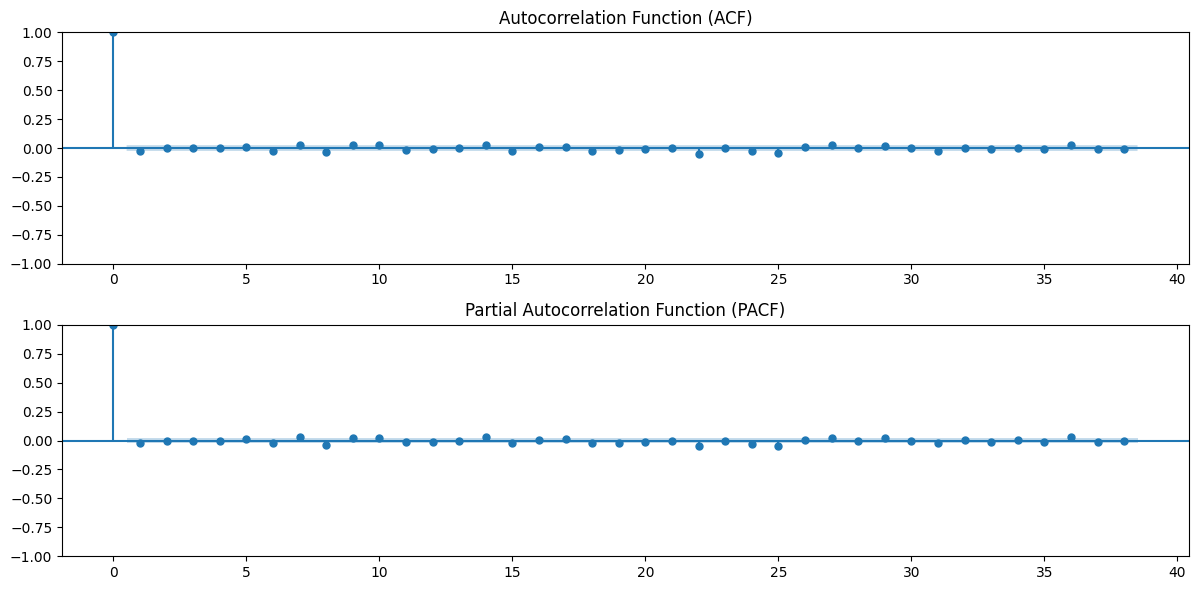

In [ ]:
plt.figure(figsize=(12, 6))

# ACF plot
plt.subplot(211)
plot_acf(ts_diff, ax=plt.gca())
plt.title("Autocorrelation Function (ACF)")

# PACF plot
plt.subplot(212)
plot_pacf(ts_diff, ax=plt.gca())
plt.title("Partial Autocorrelation Function (PACF)")

plt.tight_layout()
plt.show()


In [ ]:
# Train-test split (80-20)
train_size = int(len(ts) * 0.8)
train, test = ts[0:train_size], ts[train_size:]

# Fit the ARIMA model with chosen order (1, 1, 1)
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()

# Display the summary of the model
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 4878
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -7408.599
Date:                Mon, 31 Mar 2025   AIC                          14823.199
Time:                        01:41:37   BIC                          14842.675
Sample:                             0   HQIC                         14830.034
                               - 4878                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7861      0.166      4.746      0.000       0.461       1.111
ma.L1         -0.8024      0.160     -5.006      0.000      -1.117      -0.488
sigma2         1.2218      0.011    109.816      0.0

Rolling Forecast Metrics:
RMSE: 1.815
MAE: 1.230
MSE: 3.293
MAPE: 1.10%
R-squared: 0.992


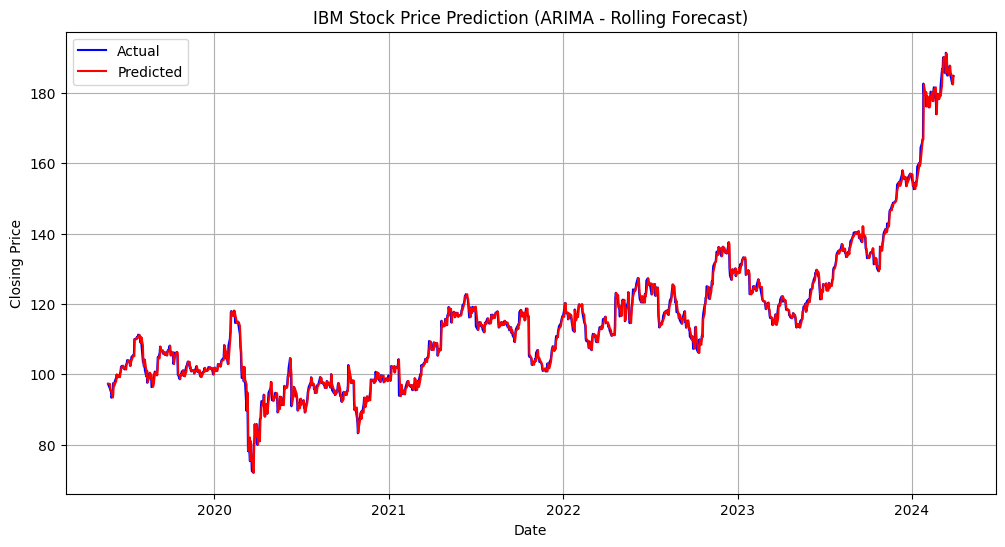

In [ ]:
# Rolling Forecast with additional metrics
history = list(train)
predictions = []

for t in range(len(test)):
    model = ARIMA(history, order=(1, 1, 1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    history.append(test[t])  # Update history with the actual value

# Calculate Metrics
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
mae = np.mean(np.abs(np.array(test) - np.array(predictions)))
mape = np.mean(np.abs((np.array(test) - np.array(predictions)) / np.array(test))) * 100
r2 = 1 - (np.sum((test - predictions) ** 2) / np.sum((test - np.mean(test)) ** 2))

# Print metrics
print(f"Rolling Forecast Metrics:")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"MSE: {mse:.3f}")
print(f"MAPE: {mape:.2f}%")
print(f"R-squared: {r2:.3f}")

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Actual', color='blue')
plt.plot(test.index, predictions, label='Predicted', color='red')
plt.title("IBM Stock Price Prediction (ARIMA - Rolling Forecast)")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend()
plt.grid(True)
plt.show()
